In [20]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import fitsio
import os

from matplotlib.backends.backend_pdf import PdfPages
import argparse


from astropy.table import join, Table
import healpy as hp
from scipy import stats

import gc as garbcol
import json

In [8]:

from sklearn.covariance import OAS, LedoitWolf, ShrunkCovariance
from sklearn.model_selection import GridSearchCV

def cov2corr(covmat):
    return covmat/np.sqrt(covmat.diagonal()[:,np.newaxis]*covmat.diagonal()[np.newaxis,:])


class Bunch:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)

        
def get_region(cat, nside=256, nest=True):
    """return masks: (bm, decals, des)"""
    if nest:
        des_pixels = np.where(Table.read('/global/cfs/cdirs/desi/users/rongpu/useful/in_des/hp_in_des_{}_nest.fits.gz'.format(nside))['in_des'])[0]
    else:
        des_pixels = np.where(Table.read('/global/cfs/cdirs/desi/users/rongpu/useful/in_des/hp_in_des_{}_ring.fits.gz'.format(nside))['in_des'])[0]

    mask_bm = cat['PHOTSYS']=='N'
    mask_des = np.in1d(cat['HPXPIXEL'], des_pixels)
    mask_decals =(~mask_bm) & (~mask_des)
    return mask_bm, mask_decals, mask_des


In [9]:

def get_tracer_binedges(tracer, zbinsize=0.05):
    """note, zbinsize doesn't change binsize of bgs"""
    tp = tracer
    # zbinsize = 0.05
    if tp[:3] == 'LRG':
        zmax = 1.1
        zmin = 0.4
        # zr = ' 0.4 < z < 1.1'

    if tp[:3] == 'ELG':
        zmax = 1.6
        zmin = 0.8

    if tp[:3] == 'QSO':
        zmax = 2.1
        zmin = 0.8
        #zr = ' 0.8 < z < 2.1 '

    if tp[:3] == 'BGS':
        zmax = 0.4
        zmin = 0.1
        zbinsize = 0.025
        # zr = ' 0.1 < z < 0.4 '
    return np.arange(zmin, zmax, zbinsize)


In [10]:
def get_tracer_selection_binedges(table, tracer):
    tp = tracer
    dt = table
    
    seld = dt['ZWARN'] != 999999
    seld &= dt['ZWARN']*0 == 0

    cols = list(dt.dtype.names)
    if 'Z' in cols:
        print(tp+' Z column already in full file')
        zcol = 'Z'
    else:
        zcol = 'Z_not4clus'

    zbinsize = 0.05
    if tp[:3] == 'LRG':
        z_suc= dt['ZWARN']==0
        z_suc &= dt['DELTACHI2']>15
        zmax = 1.1
        zmin = 0.4
        # zr = ' 0.4 < z < 1.1'

    if tp[:3] == 'ELG':
        z_suc = dt['o2c'] > 0.9
        zmax = 1.6
        zmin = 0.8

    if tp[:3] == 'QSO':
        z_suc = dt[zcol]*0 == 0
        z_suc &= dt[zcol] != 999999
        z_suc &= dt[zcol] != 1.e20
        zmax = 2.1
        zmin = 0.8
        #zr = ' 0.8 < z < 2.1 '

    if tp[:3] == 'BGS':
        z_suc = dt['ZWARN']==0
        z_suc &= dt['DELTACHI2']>40
        zmax = 0.4
        zmin = 0.1
        zbinsize = 0.025
        # zr = ' 0.1 < z < 0.4 '

    selz = (dt[zcol] > zmin) & (dt[zcol] < zmax)
    seld &= z_suc
    seld &= selz
    binedges = np.arange(zmin, zmax+zbinsize, zbinsize)
    print(f'Cutting {(1-seld.mean())*100:.2f}% of {tp} objects for bad z')
    return seld, binedges

In [11]:
def load_data(tp, gc, veto='_HPmapcut', blinded=True, irandom=0):

    if blinded == False:
        catdir_data = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6.1/'
        # catdir_data = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/' ## unnormed RF
        fn_data = catdir_data + tp + '_full' + veto + '.dat.fits'
        fn_random = catdir_data + tp + f'_{irandom}' + '_full' + veto + '.ran.fits'
    else:
        catdir_data = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/'
        fn_data = catdir_data + tp + '_'+gc+'_clustering.dat.fits'
        fn_random = catdir_data + tp + '_'+gc+f'_{irandom}_clustering.ran.fits'
    
    print(f'Loading {fn_data}')
    data = Table(fitsio.read(fn_data))
    random = Table(fitsio.read(fn_random))
    if blinded:
        return data, random
    else:
        ##get selection of good data (does not use returned binedges)
        seld, _ = get_tracer_selection_binedges(data, tracer=tp)
        return data[seld], random


def load_mock(imock, tp_mock, gc):
    catdir_mock = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock'+str(imock)+'/v2/'
    # catdir_mock = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock'+str(imock)+'/'

    fn_data = catdir_mock + tp_mock + '_'+gc+'_clustering.dat.fits'
    fn_random = catdir_mock + tp_mock + '_'+gc+'_0_clustering.ran.fits'

    data_mock = Table(fitsio.read(fn_data))
    random_mock = Table(fitsio.read(fn_random))
    
    return data_mock, random_mock

# def get_mock_nz_for_subregions(data_mock, random_mock, subregions):
    # '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/'

## unblind data has follow cols:
('TARGETID',
 'MWS_TARGET',
 'SUBPRIORITY',
 'PRIORITY_INIT',
 'TARGET_STATE',
 'TIMESTAMP',
 'LOCATION',
 'TILEID',
 'TILELOCID',
 'LASTNIGHT',
 'Z_not4clus',
 'ZERR',
 'ZWARN',
 'CHI2',
 'COEFF',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'FIBER',
 'COADD_FIBERSTATUS',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'COADD_NUMEXP',
 'COADD_EXPTIME',
 'COADD_NUMNIGHT',
 'MEAN_DELTA_X',
 'RMS_DELTA_X',
 'MEAN_DELTA_Y',
 'RMS_DELTA_Y',
 'MEAN_PSF_TO_FIBER_SPECFLUX',
 'TSNR2_ELG_B',
 'TSNR2_LYA_B',
 'TSNR2_BGS_B',
 'TSNR2_QSO_B',
 'TSNR2_LRG_B',
 'TSNR2_ELG_R',
 'TSNR2_LYA_R',
 'TSNR2_BGS_R',
 'TSNR2_QSO_R',
 'TSNR2_LRG_R',
 'TSNR2_ELG_Z',
 'TSNR2_LYA_Z',
 'TSNR2_BGS_Z',
 'TSNR2_QSO_Z',
 'TSNR2_LRG_Z',
 'TSNR2_ELG',
 'TSNR2_LYA',
 'TSNR2_BGS',
 'TSNR2_QSO',
 'TSNR2_LRG',
 'ZWARN_MTL',
 'Z_QN',
 'Z_QN_CONF',
 'IS_QSO_QN',
 'PRIORITY_ASSIGNED',
 'GOODPRI',
 'GOODHARDLOC',
 'LOCATION_ASSIGNED',
 'TILELOCID_ASSIGNED',
 'GOODTSNR',
 'sort',
 'NTILE',
 'TILES',
 'TILELOCIDS',
 'BRICKID',
 'BRICKNAME',
 'MORPHTYPE',
 'RA',
 'DEC',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'MASKBITS',
 'SHAPE_R',
 'PHOTSYS',
 'DESI_TARGET',
 'BGS_TARGET',
 'COMP_TILE',
 'FRACZ_TILELOCID',
 'lrg_mask',
 'FRAC_TLOBS_TILES',
 'WEIGHT_ZFAIL',
 'mod_success_rate',
 'WEIGHT_SN',
 'WEIGHT_FKP',
 'WEIGHT_RF')

Blinded data only has following columns:
    
['TARGETID',
 'NTILE',
 'TILES',
 'RA',
 'DEC',
 'WEIGHT_ZFAIL',
 'WEIGHT_SN',
 'WEIGHT_FKP',
 'Z',
 'WEIGHT_SYS',
 'WEIGHT',
 'WEIGHT_COMP',
 'NX',
 'WEIGHT_RF']

## Functions for computing n(z) and Ks tests

In [12]:
from scipy.stats import ks_2samp

from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    """compute ks test for two datasets with weights."""
    ## equiv to asymptotic unweighted method in scipy
    ## from https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob


In [13]:
import numpy.lib.recfunctions

def is_SGC(RA, DEC): ### True if in SGC, else in NGC
    return  (RA<77) | (RA>300) #(DEC<=32.375) |## changed to RA < 77 from 70 since the mocks go up that high and was seeing a sharp line in decals at 70
    
def get_data_nz(tp, gc, weightcols=[None, 'WEIGHT_SN', 'WEIGHT_RF'], nside=256, blinded=True, zbinsize=0.05):
    """
    Get n(z) for each region in the galactic cap (gc) of the given tracer (tp). 
    Also return ks tests for the regions coming from different distributions. Does for each weightcol given in weightcols.
    
    Returns (nz_arrs, ks_dict), where nz_arr[weightcol][region] gives binned n(z) for binedges in nz_arr[binedges].
    ks_dict has form ks_dict['weighted'][weightcol] and ks_dict['unweighted'][weightcol], for using a weighted and unweighted ks_test (i.e. if the CDFs includes weights)    
    """
    data, random = load_data(tp, gc, blinded=blinded)
    data['HPXPIXEL'] = hp.ang2pix(nside, data['RA'], data['DEC'], lonlat=True, nest=True)
    random['HPXPIXEL'] = hp.ang2pix(nside, random['RA'], random['DEC'], lonlat=True, nest=True)

    bins = get_tracer_binedges(tp, zbinsize=zbinsize)
    nz_arrs = {}
    nz_arrs['binedges'] = bins
    ks_dict = {}

    if gc=='NGC':
        regions = ['decals', 'bass']
    elif gc=='SGC':
        regions = ['decals', 'des']
    else:
        raise Exception
    
    ks_dict['weighted'] = {}
    ks_dict['unweighted'] = {}
    for weightcol in weightcols:
        nz_arrs[weightcol] = {}
        ks_dict['weighted'][weightcol] = {}
        ks_dict['unweighted'][weightcol] = {}
        for region in regions:
            nz_arrs[weightcol][region] = np.zeros(len(bins)-1)

    masks_mdat = {}
    masks_mrand = {}
    
    ## will be full footprint if on data
    masks_mdat['bass'], masks_mdat['decals'], masks_mdat['des'] = get_region(data) ##region masks for mock data
    masks_mrand['bass'], masks_mrand['decals'], masks_mrand['des'] = get_region(random) ##region masks for mock data
    ## further restrict decals to just NGC or SGC
    if gc == 'NGC':
        masks_mrand['decals'] &= (~is_SGC(random['RA'], random['DEC']))
        masks_mdat['decals'] &= (~is_SGC(data['RA'], data['DEC']))
    else:
        masks_mrand['decals'] &= (is_SGC(random['RA'], random['DEC']))
        masks_mdat['decals'] &= (is_SGC(data['RA'], data['DEC']))
    
    if 'Z' in data.colnames:
        zcol = 'Z'
    else:
        zcol = 'Z_not4clus'
    
    ## remember the z and weights of the first region so that can compute a weighted ks_test with the second region (for each weightcol)
    z1, w1 = None, None

    ## compute for all weight columns
    for iw, weightcol in enumerate(weightcols):
        print('\nData')
        print(weightcol)
        for region in regions:
            if iw==0:
                plt.plot(data['RA'][masks_mdat[region]], data['DEC'][masks_mdat[region]], '.', ms=2, alpha=.3)
                plt.title(f'{region} (Data)')
                plt.show()
            print(region)
            if masks_mdat[region].sum()>0:
                
                if blinded: ## apply same weights to randoms
                    if weightcol=='WEIGHT_SN': ##included in fiducial
                        mynorm = np.sum(random[masks_mrand[region]]['WEIGHT'])/2500
                        weights = (data['WEIGHT'])[masks_mdat[region]]
                        # nz_arrs[weightcol][region],_ = np.histogram(data['Z'][masks_mdat[region]], bins=bins, weights=weights/mynorm)
                        
                    elif weightcol == 'WEIGHT_RF': ## divide out fiducial SN weight and add the RF one
                        mynorm = np.sum((random['WEIGHT']/random['WEIGHT_SN']*random['WEIGHT_RF'])[masks_mrand[region]])/2500
                        weights = (data['WEIGHT']/data['WEIGHT_SN']*data['WEIGHT_RF'])[masks_mdat[region]]
                        
                    elif weightcol is None: ## divide out fiducial SN weight
                        mynorm = np.sum((random['WEIGHT']/random['WEIGHT_SN'])[masks_mrand[region]])/2500
                        weights = (data['WEIGHT']/data['WEIGHT_SN'])[masks_mdat[region]]
                    else:
                        print(f'enter WEIGHT_RF, WEIGHT_SN, or None. You put {weightcol}')
                        raise Exception
                
                ## not blinded, different weight columns, and don't apply any to randoms, per Ashley's message in group with Rongpu   
                else: 
                    if weightcol is None: ## no imaging weights
                        weights = (data['WEIGHT_ZFAIL']/data['FRACZ_TILELOCID']/data['FRAC_TLOBS_TILES'])[masks_mdat[region]]
                        mynorm = np.sum(masks_mrand[region])/2500
                    else:
                        weights = (data['WEIGHT_ZFAIL']*data[weightcol]/data['FRACZ_TILELOCID']/data['FRAC_TLOBS_TILES'])[masks_mdat[region]]
                        mynorm = np.sum(masks_mrand[region])/2500
                if z1 is None: # remember so as to compare with next region
                    z1 = data[zcol][masks_mdat[region]]
                    w1 = weights[:]
                else:
                    ks_d, prob = ks_weighted(z1, data[zcol][masks_mdat[region]], w1, weights)
                    ks_dict['weighted'][weightcol] = (prob, ks_d)

                    res_unw = ks_2samp(z1, data[zcol][masks_mdat[region]])
                    ks_dict['unweighted'][weightcol] = (res_unw.pvalue, res_unw.statistic)
                
                print(f'Area = {mynorm}')
                print(f'Ngal/sqdeg = {weights.sum()/mynorm}')
                nz_arrs[weightcol][region],_ = np.histogram(data[zcol][masks_mdat[region]], bins=bins, weights=weights/mynorm)
    return nz_arrs, ks_dict



In [14]:
import copy
from astropy.table import vstack

def load_spmaps(tp, zdw='', indir='/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6.1/'):
    ## merge N and S maps
    mfn = fitsio.read(indir+'hpmaps/'+tp+zdw+'_mapprops_healpix_nested_nside256_N.fits')
    mfs = fitsio.read(indir+'hpmaps/'+tp+zdw+'_mapprops_healpix_nested_nside256_S.fits')

    combomaps = {}
    for mymap in mfn.dtype.names:
        combomaps[mymap] = copy.deepcopy(mfn[mymap])
        combomaps[mymap][mfn[mymap]==0] = mfs[mymap][mfn[mymap]==0]

    dmaps = [('EBV','EBV_MPF_Mean_FW15'),('EBV','EBV_SGF14')]
    for map_pair in dmaps:
        map1 = None
        for i,mf in enumerate((mfn, mfs)):
            m1 = mf[map_pair[0]]
            m2 = mf[map_pair[1]]
            sel = (m1 == hp.UNSEEN)
            sel |= (m2 == hp.UNSEEN)
            if map1 is None:
                map1 = m1-m2
            else:
                map2 = m1-m2
        combotag = f'{map_pair[0]} - {map_pair[1]}'
        combo = copy.deepcopy(map1)
        combo[(map1==0)] = map2[map1==0]
        combomaps[combotag] = combo
        
    ## add desi dEBV map
    ## NOTE THESE ARE IN RING
    dirmap = '/dvs_ro/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
    nside = 256#64
    nest = False
    eclrs = ['gr','rz']
    for ec in eclrs:
        ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
        combomap = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
        combotag = f'EBV_DESI_{ec.upper()} - EBV_SFD'
        # hp.mollview(combomap)
        combomaps[combotag] = hp.reorder(combomap, r2n=True)
        # spmap = map_pair[0]+' - '+map_pair[1]


    sky_g = np.zeros(256*256*12)
    f = fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_256_north.fits')
    pixr = f['HPXPIXEL']
    pix_nest = hp.ring2nest(256,pixr)
    for i in range(0,len(f)):
        pix = pix_nest[i]#f['HPXPIXEL'][i]
        sky_g[pix] = f['sky_median_g'][i]

    f = fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_256_south.fits')
    pix = f['HPXPIXEL']
    pix_nest = hp.ring2nest(256,pix)
    for i in range(0,len(f)):
        pix = pix_nest[i]#f['HPXPIXEL'][i]
        sky_g[pix] = f['sky_median_g'][i]
    combomaps['sky_median_g'] = sky_g


    sag = np.load('/global/cfs/cdirs/desi/survey/catalogs/extra_regressis_maps/sagittarius_stream_256.npy')
    combomaps['sagstream'] = sag
    return combomaps
    

In [15]:

def get_data_nz_perc_map(data, random, tp, NorS, splitmap, quants_lohi=[0.4, 0.6], weightcols=[None, 'WEIGHT_SN', 'WEIGHT_RF'], nside=256, zbinsize=0.05, splitmaptag='', saveplotdir=None, density=False):
    """get n(z) and ks test dicts for map splits. Similar to get_data_nz(), but the split regions are not decals vs non-decals, but instead high and low regions of the given imaging survey property map.
    splitmap has shape of healpix map. NorS is 'N' or 'S', corresponding to BASS or decals+des, respectively (note this is different from the other tests, where the northern part of decals is included in the NGC.
    quants_lohi gives the quantiles to split the map on (will compare n(z) of gals below the quants_lohi[0] quantile in the SP map vs those above quants_lohi[1].
    E.g. Set to [0.5, 0.5] to compare top and bottom halves. Default is 0.4, 0.6 to increase signal to noise, since many points will be near 0.5 for lots of spmaps."""
    bins = get_tracer_binedges(tp, zbinsize=zbinsize)
    nz_arrs = {}
    nz_arrs['binedges'] = bins
    ks_dict = {}

    if NorS == 'N':
        gc = 'NGC'
    elif NorS == 'S':
        gc = 'SGC'
    regions = [f'<{quants_lohi[0]*100}', f'>{quants_lohi[1]*100}']
    
    ks_dict['weighted'] = {}
    ks_dict['unweighted'] = {}
    for weightcol in weightcols:
        nz_arrs[weightcol] = {}
        ks_dict['weighted'][weightcol] = {}
        ks_dict['unweighted'][weightcol] = {}
        for region in regions:
            nz_arrs[weightcol][region] = np.zeros(len(bins)-1)

    if 'HPXPIXEL' not in data.colnames:
        assert len(splitmap) == hp.nside2npix(256)
        data['HPXPIXEL'] = hp.ang2pix(256, data['RA'], data['DEC'], lonlat=True, nest=True)
        random['HPXPIXEL'] = hp.ang2pix(256, random['RA'], random['DEC'], lonlat=True, nest=True)
        
    ## sp values for galaxies in region specified region
    dat_spval = splitmap[data['HPXPIXEL'][data['PHOTSYS']==NorS]]
    rand_spval = splitmap[random['HPXPIXEL'][random['PHOTSYS']==NorS]]
    
    
    masks_mdat = {}
    masks_mrand = {}
    
    ## mask for full data 
    masks_mdat[regions[0]] = (splitmap[data['HPXPIXEL']] <= (np.quantile(dat_spval, quants_lohi[0]))) * (data['PHOTSYS']==NorS)
    masks_mdat[regions[1]] = (splitmap[data['HPXPIXEL']] > (np.quantile(dat_spval, quants_lohi[1]))) * (data['PHOTSYS']==NorS)
    print(f'quant: {np.quantile(dat_spval, quants_lohi[0])}')
    masks_mrand[regions[0]] = (splitmap[random['HPXPIXEL']] <= (np.quantile(rand_spval, quants_lohi[0]))) * (random['PHOTSYS']==NorS)
    masks_mrand[regions[1]] = (splitmap[random['HPXPIXEL']] > (np.quantile(rand_spval, quants_lohi[1]))) * (random['PHOTSYS']==NorS)
    
    if 'Z' in data.colnames:
        zcol = 'Z'
    else:
        zcol = 'Z_not4clus'
    
    ## remember the z and weights of the first region so that can compute a weighted ks_test with the second region (for each weightcol)
    z1, w1 = None, None

    ## compute for all weight columns
    for iw, weightcol in enumerate(weightcols):
        print(f'\n{splitmaptag}: {weightcol}:')
        for ir,region in enumerate(regions):
            if iw==0:
                plt.plot(data['RA'][masks_mdat[region]][::64], data['DEC'][masks_mdat[region]][::64], '.', ms=2, alpha=.2)

                if ir==1:
                    plt.grid()
                    plt.plot([],[], '.', c='C0', label=regions[0])
                    plt.plot([],[], '.', c='C1', label=regions[1])
                    plt.legend()
                    plt.title(f'{splitmaptag} (data)')
                    if saveplotdir is not None:
                        plt.savefig(saveplotdir + f'/data_{tp}_{NorS}_{splitmaptag}_{quants_lohi[0]}_{quants_lohi[1]}.png')
                    # plt.show()
                    plt.close(plt.gcf())
                        
            print(f'{region}:')
            if masks_mdat[region].sum()>0:
#                 if blinded: ## apply same weights to randoms
#                     if weightcol=='WEIGHT_SN': ##included in fiducial
#                         mynorm = np.sum(random[masks_mrand[region]]['WEIGHT'])/2500
#                         weights = (data['WEIGHT'])[masks_mdat[region]]
#                         # nz_arrs[weightcol][region],_ = np.histogram(data['Z'][masks_mdat[region]], bins=bins, weights=weights/mynorm)
                        
#                     elif weightcol == 'WEIGHT_RF': ## divide out fiducial SN weight and add the RF one
#                         mynorm = np.sum((random['WEIGHT']/random['WEIGHT_SN']*random['WEIGHT_RF'])[masks_mrand[region]])/2500
#                         weights = (data['WEIGHT']/data['WEIGHT_SN']*data['WEIGHT_RF'])[masks_mdat[region]]
                        
#                     elif weightcol is None: ## divide out fiducial SN weight
#                         mynorm = np.sum((random['WEIGHT']/random['WEIGHT_SN'])[masks_mrand[region]])/2500
#                         weights = (data['WEIGHT']/data['WEIGHT_SN'])[masks_mdat[region]]
#                     else:
#                         print(f'enter WEIGHT_RF, WEIGHT_SN, or None. You put {weightcol}')
#                         raise Exception
                # else: ## not blinded, different weight columns, and don't apply any to randoms, per Ashley's message in group with Rongpu
                if weightcol is None: ## no imaging weights
                    weights = (data['WEIGHT_ZFAIL']/data['FRACZ_TILELOCID']/data['FRAC_TLOBS_TILES'])[masks_mdat[region]]
                    mynorm = np.sum(masks_mrand[region])/2500
                else:
                    weights = (data['WEIGHT_ZFAIL']*data[weightcol]/data['FRACZ_TILELOCID']/data['FRAC_TLOBS_TILES'])[masks_mdat[region]]
                    mynorm = np.sum(masks_mrand[region])/2500
                if z1 is None: # remember so as to compare with next region
                    z1 = data[zcol][masks_mdat[region]]
                    w1 = weights[:]
                else:
                    ks_d, prob = ks_weighted(z1, data[zcol][masks_mdat[region]], w1, weights)
                    ks_dict['weighted'][weightcol] = (prob, ks_d)

                    res_unw = ks_2samp(z1, data[zcol][masks_mdat[region]])
                    ks_dict['unweighted'][weightcol] = (res_unw.pvalue, res_unw.statistic)
                
                print(f'Area = {mynorm}')
                print(f'Ngal/sqdeg = {weights.sum()/mynorm}')
                nz_arrs[weightcol][region],_ = np.histogram(data[zcol][masks_mdat[region]], bins=bins, weights=weights/mynorm, density=density)
    return nz_arrs, ks_dict

In [21]:
splitmaps = load_spmaps(tp='LRG')

def plot_single_split():
    data_mock_n, random_mock_n = load_mock(0, tp_mock='LRG_ffa', gc='NGC')
    NorS = 'S'
    quants_lohi = [.4, .6]
    regions = [f'<{quants_lohi[0]*100}', f'>{quants_lohi[1]*100}']


    masks_mdat={}
    masks_mrand={}
    splitmap = splitmaps['EBV_CHIANG_SFDcorr']
    ## sp values for galaxies in region specified region
    dat_spval = splitmap[data_mock['HPXPIXEL'][data_mock['PHOTSYS']==NorS]]
    rand_spval = splitmap[random_mock['HPXPIXEL'][random_mock['PHOTSYS']==NorS]]

    assert (dat_spval==hp.UNSEEN).sum()==0
    assert (rand_spval==hp.UNSEEN).sum()==0


    ## mask for full data 
    masks_mdat[regions[0]] = (splitmap[data_mock['HPXPIXEL']] <= (np.quantile(dat_spval, quants_lohi[0]))) * (data_mock['PHOTSYS']==NorS)
    masks_mdat[regions[1]] = (splitmap[data_mock['HPXPIXEL']] > (np.quantile(dat_spval, quants_lohi[1]))) * (data_mock['PHOTSYS']==NorS)

    masks_mrand[regions[0]] = (splitmap[random_mock['HPXPIXEL']] <= (np.quantile(rand_spval, quants_lohi[0]))) * (random_mock['PHOTSYS']==NorS)
    masks_mrand[regions[1]] = (splitmap[random_mock['HPXPIXEL']] > (np.quantile(rand_spval, quants_lohi[1]))) * (random_mock['PHOTSYS']==NorS)

    for region in regions:
        plt.plot(data_mock['RA'][masks_mdat[region]], data_mock['DEC'][masks_mdat[region]], '.', ms=1, alpha=.1, label=region)
                

In [22]:

def get_mock_nz_perc_map(tp_mock, NorS, splitmap_array, quants_lohi=[0.4, 0.6], Nmocks=25, nside=256, bins=None, zbinsize=0.05, plot_splitmap=True, density=False):
    """load mocks for tracer tp_mock in N or S region (NorS). For each mock, for each splitmap in splitmap_array (dict), compute the n(z) of tracer galaxies that are in bottom (top) quantile 
    by splitmap in the NorS region, where bottom and top thresholds are given by quants_lohi (default is bottom 40% and top 40%).
    Do for unweighted, RF and SysNet weights. Also store a KS-test statistic and p-value that the top and bottom quantile n(z)'s come from the same distribution.
    Returns nested dictionaries:
        mock_nz_arrs[splitmap][quantile_region] = (Nbins, Nmocks)
        ksdat_dict[splitmap][{weighted, unweighted}] = pval, ks_statistic (shape (Nmocks, 2))
    if density = True, then normalize all n(z) to 1 (insensitive to any number density differences between regions)
    
    Return (mock_nz_arrs, ksdat_dict)
    """

    if bins is None:
        bins = get_tracer_binedges(tp_mock, zbinsize=zbinsize)
    mock_nz_arrs = {}
    ksdat_dict = {}
    
    if NorS == 'N':
        gc = 'NGC'
    elif NorS == 'S':
        gc = 'SGC'
        
    ## region names
    regions = [f'<{quants_lohi[0]*100}', f'>{quants_lohi[1]*100}']
    mock_nz_arrs['regions'] = regions
    
    ## initialize results arrays
    for spmap in splitmap_array.keys():
        mock_nz_arrs[spmap] = {}
        mock_nz_arrs[spmap]['binedges'] = bins
        for region in regions:
            mock_nz_arrs[spmap][region] = np.zeros((len(bins)-1, Nmocks))
            
        ksdat_dict[spmap] = {'weighted':[], 'unweighted':[]}

    for imock in range(Nmocks):
        if imock%5==0:
            print(f'Mock {imock}/{Nmocks}...')
            
        data_mock, random_mock = load_mock(imock, tp_mock=tp_mock, gc=gc) 
        if NorS=='S':
            ## doing N/S splits, but mocks are stored as NGC and SGC, so need to load both for S 
            data_mock_2, random_mock_2 = load_mock(imock, tp_mock=tp_mock, gc='NGC')
            data_mock = vstack((data_mock, data_mock_2), join_type='exact')
            random_mock = vstack((random_mock, random_mock_2), join_type='exact')
        
        data_mock['HPXPIXEL'] = hp.ang2pix(nside, data_mock['RA'], data_mock['DEC'], lonlat=True, nest=True)
        random_mock['HPXPIXEL'] = hp.ang2pix(nside, random_mock['RA'], random_mock['DEC'], lonlat=True, nest=True)
        if imock==0:
            print(f"Data frac in {NorS}: {(data_mock['PHOTSYS']==NorS).mean()*100:.1f}%")
            print(f"Random frac in {NorS}: {(random_mock['PHOTSYS']==NorS).mean()*100:.1f}%")

        for spmap in splitmap_array.keys():
            masks_mdat = {}
            masks_mrand = {}
            
            splitmap = splitmap_array[spmap]
            ## sp values for galaxies in region specified region
            dat_spval = splitmap[data_mock['HPXPIXEL'][data_mock['PHOTSYS']==NorS]]
            rand_spval = splitmap[random_mock['HPXPIXEL'][random_mock['PHOTSYS']==NorS]]
            
            assert (dat_spval==hp.UNSEEN).sum()==0
            assert (rand_spval==hp.UNSEEN).sum()==0
            
            ## mask for full data 
            masks_mdat[regions[0]] = (splitmap[data_mock['HPXPIXEL']] <= (np.quantile(dat_spval, quants_lohi[0]))) * (data_mock['PHOTSYS']==NorS)
            masks_mdat[regions[1]] = (splitmap[data_mock['HPXPIXEL']] > (np.quantile(dat_spval, quants_lohi[1]))) * (data_mock['PHOTSYS']==NorS)

            masks_mrand[regions[0]] = (splitmap[random_mock['HPXPIXEL']] <= (np.quantile(rand_spval, quants_lohi[0]))) * (random_mock['PHOTSYS']==NorS)
            masks_mrand[regions[1]] = (splitmap[random_mock['HPXPIXEL']] > (np.quantile(rand_spval, quants_lohi[1]))) * (random_mock['PHOTSYS']==NorS)

            ## for storing first region n(z), in order to compare with second region in the ks test
            z1, w1 = None, None

            for ir,region in enumerate(regions):

                # mynorm = np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500 ## FOR CLUSTERING MEASUREMENTS
                mynorm = np.sum(masks_mrand[region])/2500 ## FOR N(Z) [THOUGH DOESN'T ACCT FOR QSO VETO MASK IN DATA]
                # norm = np.sum(random_mock[mymask]['WEIGHT']*random_mock[mymask]['WEIGHT_FKP'])/2500
                mock_nz_arrs[spmap][region][:, imock],_ = np.histogram(data_mock['Z'][masks_mdat[region]], bins=bins, weights=data_mock['WEIGHT_COMP'][masks_mdat[region]]/mynorm, density=density)
                # mock_nz_arrs[region][:, imock],_ = np.histogram(data_mock['Z'][masks_mdat[region]], bins=bins, weights=data_mock['WEIGHT'][masks_mdat[region]]/mynorm) ## fo clustering
                if imock==0:
                    print(f'\n{spmap} {region}:')
                    print(f'Area = {mynorm}')
                    print(f"Ngal/sqdeg = {data_mock['WEIGHT'][masks_mdat[region]].sum()/mynorm}")
                    # print()
                    # print(np.sum(masks_mrand[region])/2500)
                    # print(np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500)
                    ## visualize split on SP map
                    if plot_splitmap:
                        plt.plot(data_mock['RA'][masks_mdat[region]][::64], data_mock['DEC'][masks_mdat[region]][::64], '.', ms=2, alpha=.2)
                        if ir==1:
                            plt.grid()
                            plt.plot([],[], '.', c='C0', label=f'{regions[0]}%')
                            plt.plot([],[], '.', c='C1', label=f'{regions[1]}%')
                            plt.legend()
                            plt.title(f'{spmap} (mock)')
                            plt.show()

                if z1 is None: # remember so as to compare with next region
                    z1 = data_mock['Z'][masks_mdat[region]]
                    w1 = data_mock['WEIGHT_COMP'][masks_mdat[region]]
                else:
                    ## do KS test and append it to corresponding SP map list (will have length Nmocks)
                    ks_d, prob = ks_weighted(z1, data_mock['Z'][masks_mdat[region]], w1, data_mock['WEIGHT_COMP'][masks_mdat[region]])
                    ksdat_dict[spmap]['weighted'].append([prob, ks_d])
                    res_unw = ks_2samp(z1, data_mock['Z'][masks_mdat[region]])
                    ksdat_dict[spmap]['unweighted'].append([res_unw.pvalue, res_unw.statistic])

    for spmap in splitmap_array.keys():
        ksdat_dict[spmap]['unweighted'] = np.array(ksdat_dict[spmap]['unweighted'])
        ksdat_dict[spmap]['weighted'] = np.array(ksdat_dict[spmap]['weighted'])
    return mock_nz_arrs, ksdat_dict

(0.0, 66.93896446228027)

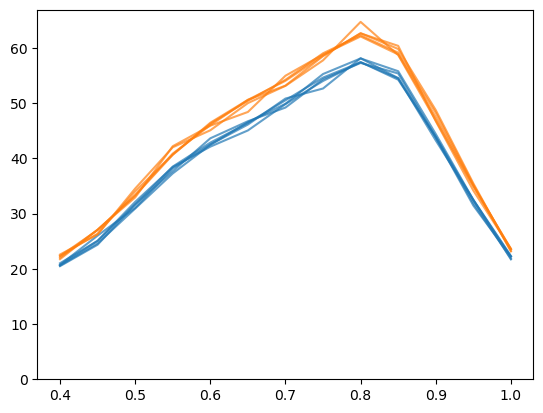

In [24]:
## test out
mynz_spsplit_mock, myksdict_spsplit_mock = get_mock_nz_perc_map('LRG_ffa',  NorS='S', splitmap_array={k: splitmaps[k] for k in ('EBV_CHIANG_SFDcorr', 'STARDENS')}, Nmocks=5)

plt.plot(mynz_spsplit_mock['EBV_CHIANG_SFDcorr']['binedges'][:-1], mynz_spsplit_mock['EBV_CHIANG_SFDcorr']['<40.0'], '-', alpha=.7, c='C0')
plt.plot(mynz_spsplit_mock['EBV_CHIANG_SFDcorr']['binedges'][:-1], mynz_spsplit_mock['EBV_CHIANG_SFDcorr']['>60.0'], '-', alpha=.7, c='C1')
plt.ylim(ymin=0)

In [37]:
## Get n(z) data for region:

nz_south_data, ksdat_south = get_data_nz('LRG', 'SGC', blinded=False)

Loading /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6.1/LRG_ffa_full_HPmapcut.dat.fits


OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6.1/LRG_ffa_full_H
Pmapcut.dat.fits


Cutting 31.22% of LRG objects for bad z
None


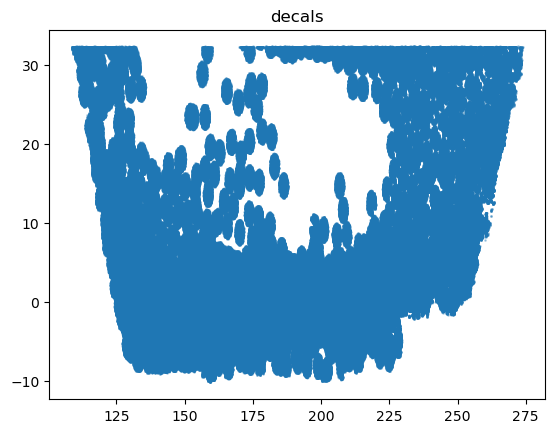

decals
Area = 2738.192
Ngal/sqdeg = 602.9214397503749


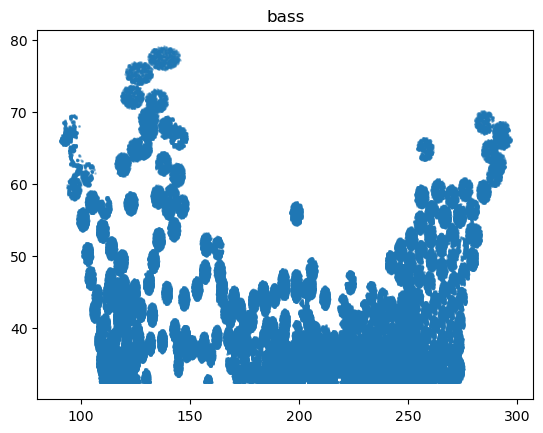

bass
Area = 1018.012
Ngal/sqdeg = 595.6716891782308
WEIGHT_SN


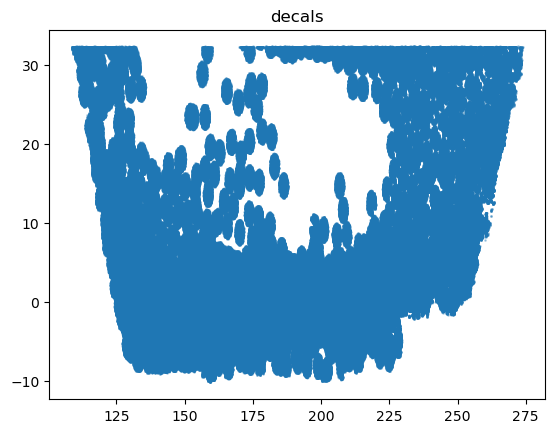

decals
Area = 2738.192
Ngal/sqdeg = 599.3463279149452


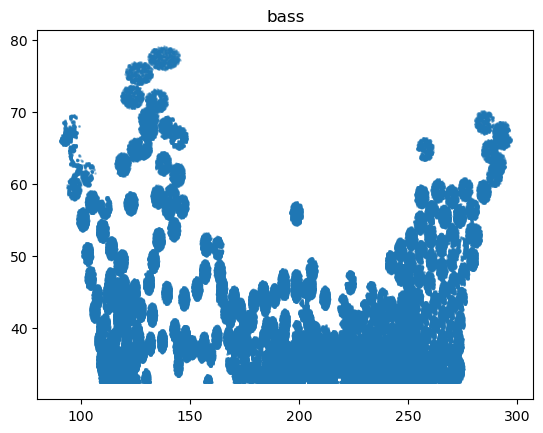

bass
Area = 1018.012
Ngal/sqdeg = 595.7295863339854
WEIGHT_RF


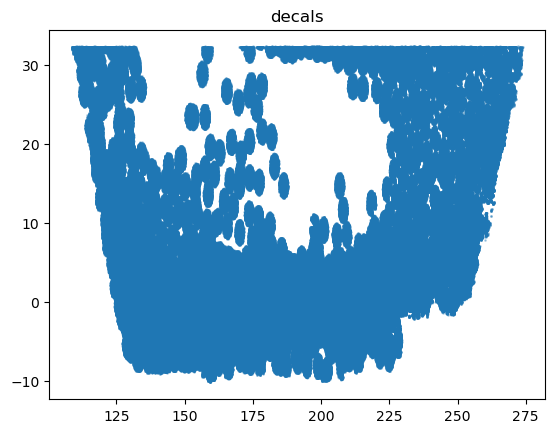

decals
Area = 2738.192
Ngal/sqdeg = 603.7563052923445


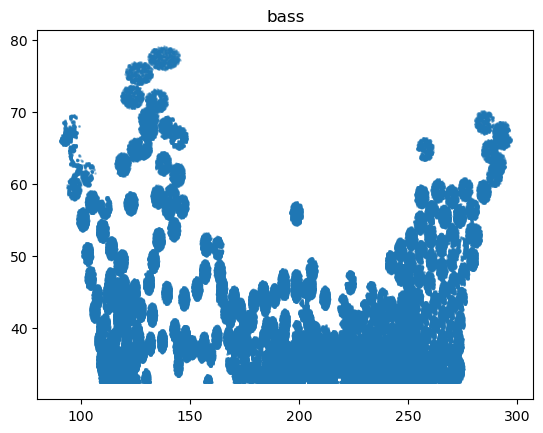

bass
Area = 1018.012
Ngal/sqdeg = 583.4580886536818


In [23]:
nz_north_data, ksdat_north = get_data_nz('LRG', 'NGC', blinded=False)

In [26]:
_=plt.hist(ksdat_south_mocks['unweighted'][:,0], bins=10, alpha=.6)
_=plt.hist(ksdat_south_mocks['weighted'][:,0], bins=10, alpha=.6)
plt.xlabel('p-val')
plt.show()

_=plt.hist(ksdat_south_mocks['unweighted'][:,1], bins=10, alpha=.6)
_=plt.hist(ksdat_south_mocks['weighted'][:,1], bins=10, alpha=.6)
plt.xlabel('p-val')
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [23]:
def print_areas():
    data_mock, random_mock = load_mock(0, tp_mock='LRG_ffa', gc='SGC') ## just sgc for now
    data_mock['HPXPIXEL'] = hp.ang2pix(256, data_mock['RA'], data_mock['DEC'], lonlat=True, nest=True)
    random_mock['HPXPIXEL'] = hp.ang2pix(256, random_mock['RA'], random_mock['DEC'], lonlat=True, nest=True)
    masks_mrand={}
    masks_mdat={}

    masks_mrand['bass'], masks_mrand['decals'], masks_mrand['des'] = get_region(random_mock, nside=256) ##region masks for mock rands
    masks_mdat['bass'], masks_mdat['decals'], masks_mdat['des'] = get_region(data_mock, nside=256) ##region masks for mock data

    for region in ['bass', 'decals', 'des']:
        print()
        print(region)
        print(np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500)
        print(np.sum(data_mock[masks_mdat[region]]['WEIGHT'])/2500)
        print(np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/np.sum(data_mock[masks_mdat[region]]['WEIGHT']))

In [120]:
masks_ddat={}
masks_ddat['bass'], masks_ddat['decals'], masks_ddat['des'] = get_region(data) ##region masks for mock data

for region in ['bass', 'decals', 'des']:
    print()
    print(region)
    print(((data['WEIGHT_ZFAIL']/data['FRACZ_TILELOCID']/data['FRAC_TLOBS_TILES'])[masks_ddat[region]]).sum()/2500)


bass
242.56037105748365

decals
999.4262289809219

des
133.0541631068112


In [23]:
# for weightcol in ['WEIGHT_SN', 'WEIGHT_FKP', 'WEIGHT_RF', 'WEIGHT_SYS']:
#     plt.hist(data[weightcol], bins=100, label=weightcol, alpha=.5)
#     print(f'{weightcol}: {data[weightcol].std():.2f}')
# # plt.yscale('log')
# plt.legend()
# plt.show()

In [24]:

def get_mock_nzs(tp_mock, gc, Nmocks=25, nside=256, bins=None, zbinsize=0.05):

    if bins is None:
        bins = get_tracer_binedges(tp_mock, zbinsize=zbinsize)
    mock_nz_arrs = {}
    mock_nz_arrs['binedges'] = bins
    # mock_nz_arrs_s = {}
    # regions = ['decals', 'des', 'bass']

    if gc=='NGC':
        regions = ['decals', 'bass']
    elif gc=='SGC':
        regions = ['decals', 'des']
    else:
        raise Exception
        
    for region in regions:
        mock_nz_arrs[region] = np.zeros((len(bins)-1, Nmocks))

    masks_mdat = {}
    masks_mrand = {}
    ksdat_dict = {'weighted':[], 'unweighted':[]} 


    for imock in range(Nmocks):
        data_mock, random_mock = load_mock(imock, tp_mock=tp_mock, gc=gc) ## just sgc for now

        data_mock['HPXPIXEL'] = hp.ang2pix(nside, data_mock['RA'], data_mock['DEC'], lonlat=True, nest=True)
        random_mock['HPXPIXEL'] = hp.ang2pix(nside, random_mock['RA'], random_mock['DEC'], lonlat=True, nest=True)

        masks_mdat['bass'], masks_mdat['decals'], masks_mdat['des'] = get_region(data_mock, nside=nside) ##region masks for mock data
        masks_mrand['bass'], masks_mrand['decals'], masks_mrand['des'] = get_region(random_mock, nside=nside) ##region masks for mock rands

        ## for storing first region n(z)
        z1, w1 = None, None
    
        for region in regions:
            
        # region = 'decals'
            # mynorm = np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500 ## FOR CLUSTERING MEASUREMENTS
            mynorm = np.sum(masks_mrand[region])/2500 ## FOR N(Z) [THOUGH DOESN'T ACCT FOR QSO VETO MASK IN DATA]
            # norm = np.sum(random_mock[mymask]['WEIGHT']*random_mock[mymask]['WEIGHT_FKP'])/2500
            mock_nz_arrs[region][:, imock],_ = np.histogram(data_mock['Z'][masks_mdat[region]], bins=bins, weights=data_mock['WEIGHT_COMP'][masks_mdat[region]]/mynorm)
            # mock_nz_arrs[region][:, imock],_ = np.histogram(data_mock['Z'][masks_mdat[region]], bins=bins, weights=data_mock['WEIGHT'][masks_mdat[region]]/mynorm) ## fo clustering
            if imock==0:
                print(f'Area = {mynorm}')
                print(f"Ngal/sqdeg = {data_mock['WEIGHT'][masks_mdat[region]].sum()/mynorm}")
                # print()
                # print(np.sum(masks_mrand[region])/2500)
                # print(np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500)
                plt.plot(data_mock['RA'][masks_mdat[region]], data_mock['DEC'][masks_mdat[region]], '.', ms=2, alpha=.3)
                plt.title(f'{region} (mock)')
                plt.show()
                
            if z1 is None: # remember so as to compare with next region
                z1 = data_mock['Z'][masks_mdat[region]]
                w1 = data_mock['WEIGHT_COMP'][masks_mdat[region]]
            else:
                ks_d, prob = ks_weighted(z1, data_mock['Z'][masks_mdat[region]], w1, data_mock['WEIGHT_COMP'][masks_mdat[region]])
                ksdat_dict['weighted'].append([prob, ks_d])
                res_unw = ks_2samp(z1, data_mock['Z'][masks_mdat[region]])
                ksdat_dict['unweighted'].append([res_unw.pvalue, res_unw.statistic])
            
    ksdat_dict['unweighted'] = np.array(ksdat_dict['unweighted'])
    ksdat_dict['weighted'] = np.array(ksdat_dict['weighted'])
        # region = 'des'
        # norm = np.sum(random_mock[masks_mrand[region]]['WEIGHT'])/2500
        # # norm = np.sum(random_mock[mymask]['WEIGHT']*random_mock[mymask]['WEIGHT_FKP'])/2500
        # mock_nz_arrs[region][:, imock],_ = np.histogram(data_mock['Z'][masks_mdat[region]], bins=bins, weights=data_mock['WEIGHT'][masks_mdat[region]]/mynorm)
    return mock_nz_arrs, ksdat_dict

In [25]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",})

def do_nz_plots(nz_data, mock_nz_arrs, gc, bins, tp, savedir='nz_validate', fnappend='', titleappend='', regions=None, density=False, return_chi2=False):
    """if pass regions, ignores galactic cap (gc). Can pass 'S' or 'N' to gc and will save in the filename.
    if density = True, then assumes n(z)'s have been normalized so reduces dof by 1.
    if return_chi2, returns chi2 of n(z) wrt mocks and chi2 of ratio regions' n(z)"""
    binmids = (bins[1:] + bins[:-1])/2
    weightcols = ['WEIGHT_SN', 'WEIGHT_RF', None]
    weighttags = {None:'raw', 'WEIGHT_SN':'SN', 'WEIGHT_RF':'RF'}
    chi2dict = {'wrt_mocks':{}, 'region_ratio':{}}
    
    if regions is None:
        if gc=='SGC':
            regions = ['des', 'decals']
        elif gc=='NGC':
            regions = ['bass', 'decals']
    
    ## Plot n(z) of each region. Shows differences between mock and data n(z)
    f, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
    plt.suptitle(f'{tp}_{gc}{titleappend}')
    for i,region in enumerate(regions):
        chi2dict['wrt_mocks'][region] = {}
        ax = axes.ravel()[i]
        _=ax.plot(binmids, mock_nz_arrs[region], '-', alpha=.3, color='gray')
        for weightcol in weightcols:
            
            print(weightcol)
            try:
                mydat = nz_data[weightcol][region]
                lw = LedoitWolf(store_precision=True, assume_centered=False)
                lw.fit(mock_nz_arrs[region].T)
                
                dof = len(mydat) ##will be same for all weightcols
                chi2dict['wrt_mocks'][region]['dof'] = dof
                
                mockmean = mock_nz_arrs[region].mean(axis=1)
                mychi2 = (mydat - mockmean).dot(lw.precision_.dot(mydat - mockmean))
                _=ax.plot(binmids, mydat, '.-', alpha=.8, lw=2, markeredgecolor='k', label=f'{weightcol}: $\chi^2={mychi2:.1f}/{dof}$')
                chi2dict['wrt_mocks'][region][weightcol] = mychi2

            except KeyError as ke:
                print(ke)
        # ax.set_title(region)
        ax.text(0.95, 0.9, region.upper(), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        ax.grid()
        ax.legend(loc='upper left')
        # ax.set_ylim(ymin=0)
        
        ax.set_xlabel('Z')
        plt.tight_layout()
    plt.savefig(f'{savedir}/nz_{gc}_{tp}{fnappend}.pdf')
    plt.show()

    ## For each region, plot n(z) as a fractional difference from the sysnet n(z) 
    ## get fractional errors from the spread of mock n(z) relative to mean
    mock_nz_arrs[region]
    f, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
    plt.title(f'{tp} {gc}{titleappend}')
    for i,region in enumerate(regions):
        ax = axes.ravel()[i]
        mockmean = mock_nz_arrs[region].mean(axis=1)
        mock_relerrs = mock_nz_arrs[region] / mockmean[:,np.newaxis]
        mock_nz_arrs_new = mock_relerrs
        _=ax.plot(binmids, mock_nz_arrs_new, '-', alpha=.2, color='gray') ##err curves
        _=ax.errorbar(binmids, mock_nz_arrs_new.mean(axis=1), mock_nz_arrs_new.std(axis=1, ddof=1), ls='', marker='.', capsize=2, lw=2, alpha=.6, color='k') ##err curves
        for weightcol in weightcols:
            print(weightcol)
            try:
                ## plot relative to fiducial weighting
                mydat = nz_data[weightcol][region] / nz_data['WEIGHT_SN'][region]
                ## compute covariance matrix
                lw = LedoitWolf(store_precision=True, assume_centered=False)
                lw.fit(mock_nz_arrs_new.T)

                # mockmean = mock_nz_arrs_new.mean(axis=1) ## mean will be 1
                mockmean = 1
                mychi2 = (mydat - mockmean).dot(lw.precision_.dot(mydat - mockmean))
                _=ax.plot(binmids, mydat, '.-', alpha=.8, lw=2, markeredgecolor='k', label=f'{weightcol}: $\chi^2={mychi2:.1f}/{len(mydat)-density}$')
            except KeyError as ke:
                print(ke)
        # ax.set_title(region)
        ax.text(0.95, 0.9, region.upper(), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        ax.grid()
        ax.legend(loc='upper left')
        ax.set_ylim(ymin=0.9, ymax=1.1)
        ax.set_ylabel(f'n(z)_[X] / n(z)_[SN] ({region})')
        ax.set_xlabel('Z')
        plt.tight_layout()
    plt.savefig(f'{savedir}/nz_{gc}_{tp}_relerr{fnappend}.pdf')
    plt.show()

    ## Plot n(z) ratio wrt decals
    f,ax = plt.subplots(figsize=(8,6))
    mock_nz_arrs_new = mock_nz_arrs[regions[0]]/mock_nz_arrs[regions[1]]
    plt.axhline(1, color='k', alpha=.4, ls='--')
    _=plt.plot(binmids, mock_nz_arrs_new, '-', alpha=.2, color='gray')
    _=ax.errorbar(binmids, mock_nz_arrs_new.mean(axis=1), mock_nz_arrs_new.std(axis=1, ddof=1), ls='', marker='.', capsize=2, lw=2, alpha=.6, color='k', label='Mocks') ##err curves
    
    chi2dict['region_ratio'] = {}
    
    for weightcol in weightcols:
        mydat = nz_data[weightcol][regions[0]]/nz_data[weightcol][regions[1]]
        lw = LedoitWolf(store_precision=True, assume_centered=False)
        lw.fit(mock_nz_arrs_new.T)
        ## wrt same n(z) (ratio=1)
        mockmean = np.ones_like(binmids)
        mychi2_1 = (mydat - mockmean).dot(lw.precision_.dot(mydat - mockmean))
        chi2dict['region_ratio'][weightcol] = mychi2_1
        dof = len(mydat)-density
        chi2dict['region_ratio']['dof'] = dof
        ## wrt to mock mean
        mockmean = mock_nz_arrs_new.mean(axis=1)
        mychi2 = (mydat - mockmean).dot(lw.precision_.dot(mydat - mockmean))
        
        _=plt.plot(binmids, mydat, '.-', alpha=.8, lw=2, markeredgecolor='k', label=f'{weightcol}: $\chi^2={mychi2_1:.1f}({mychi2:.1f})/{dof}$')
    plt.xlabel('Z')
    plt.ylabel(f'n(z)[{regions[0]}] / n(z)[{regions[1]} {gc}]')
    plt.legend()
    plt.title(f'{tp} {gc}{titleappend}')
    plt.grid()
    plt.savefig(f'{savedir}/nz_ratio_{gc}_{tp}{fnappend}.pdf')
    plt.show()
    return chi2dict


In [17]:

    
def do_nz_ks_plots_splitmaps(tp, gc, splitmap_array, savedir='nz_validate/spmap_splits/', zbinsize=0.05, Nmocks=25, density=False,
                            save_chi2=True):
    """run get_data_nz_perc_map() for each splitmap in splitmap_array using default split quantiles. save plots for each splitmap and save a json file with all the chi2 values."""
    if savedir is not None:
        os.makedirs(savedir, exist_ok=True)
        os.makedirs(savedir + 'ks_stat', exist_ok=True)
        os.makedirs(savedir + 'split_plots', exist_ok=True)
    print('\n---------------------')
    print(f'Doing {tp}, {gc}')
    # my_data_nz, my_data_ksdat = get_data_nz(tp, gc, blinded=False, zbinsize=zbinsize)
    ## no sagstream in North
    if (gc=='N') * 'sagstream' in splitmap_array.keys():
        splitmap_array = {key:splitmap_array[key] for key in splitmap_array.keys() if key != 'sagstream'}
        
    data, random = load_data(tp, gc, blinded=False)
    ## get data_nz for each map split
    data_nz_splitmaps, data_ksdat_splitmaps = {}, {}
    for spmaptag in list(splitmap_array.keys()):
        mynz_spsplit, myksdict_spsplit = get_data_nz_perc_map(data, random, tp, NorS=gc, splitmap=splitmap_array[spmaptag], splitmaptag=spmaptag, 
                                                              density=density, saveplotdir=savedir+'split_plots/')
        data_nz_splitmaps[spmaptag] = mynz_spsplit
        data_ksdat_splitmaps[spmaptag] = myksdict_spsplit
        
    del data
    del random
    garbcol.collect()
        
    if tp[:7] == 'ELG_LOP':
        tpmock = 'ELG_LOP_ffa'
    else:
        tpmock = tp + '_ffa'
        
    ## dict with mock_nz_arrs for each splitmap
    mock_nz_arrs_splitmaps, mock_ksdat_splitmaps = get_mock_nz_perc_map(tpmock,  NorS=gc, bins=data_nz_splitmaps[spmaptag]['binedges'], 
                                                                    splitmap_array=splitmap_array, Nmocks=Nmocks, plot_splitmap=False, density=density)
    chi2dict = {}
    
    ## save plots for each splitmap    
    for spmaptag in list(splitmap_array.keys()):
        regionstag = f'{mock_nz_arrs_splitmaps["regions"][0].replace("<","lt")}_{mock_nz_arrs_splitmaps["regions"][1].replace(">","gt")}'

        ## nz plots
        my_data_nz = data_nz_splitmaps[spmaptag]
        my_mock_nz_arrs = mock_nz_arrs_splitmaps[spmaptag]
        assert np.allclose(my_data_nz['binedges'], my_mock_nz_arrs['binedges'])
        chi2dict[spmaptag] = do_nz_plots(my_data_nz, my_mock_nz_arrs, bins=my_data_nz['binedges'], gc=gc, tp=tp, savedir=savedir, 
                    regions=mock_nz_arrs_splitmaps['regions'], fnappend=f'_{spmaptag}_{regionstag}', titleappend=f': {spmaptag}', density=density,
                              return_chi2=True)
        # my_mock_ksdat_both = mock_ksdat_splitmaps[spmaptag]
        
        
        ## DO KS_TEST PLOTS 
        my_mock_ksdat = mock_ksdat_splitmaps[spmaptag]['weighted']
        my_data_ksdat = data_ksdat_splitmaps[spmaptag]['weighted']
        ## ks pvalue plot (weighted)
        _ =plt.hist(np.array(my_mock_ksdat)[:,0], bins=np.logspace(np.floor(np.log10(np.array(my_mock_ksdat)[:,0].min())), 1, 20), label=f'Mocks, min={np.array(my_mock_ksdat)[:,0].min()*100:.1g}%')
        for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
        # for i,key in enumerate(my_data_ksdat.keys()):
            myp = my_data_ksdat[key][0]
            plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp*100:.1g}%, rank {(myp>np.array(my_mock_ksdat)[:,0]).sum()}/{len(np.array(my_mock_ksdat)[:,0])}')
        plt.legend()
        plt.xlim(xmin=max(1e-30, np.array(my_mock_ksdat)[:,0].min()))
        plt.xscale('log')

        plt.xlabel('KS p-value')
        plt.title(f"{tp}, {gc}: {spmaptag} {regionstag}")
        plt.savefig(f'{savedir}/ks_stat/ks_pval_hist_{gc}_{tp}_{spmaptag}_{regionstag}.pdf')
        plt.show()

        ## ks statistic plot (weighted)
        _ =plt.hist(np.array(my_mock_ksdat)[:,1], bins=10, alpha=.8, label=f'Mocks, max={np.array(my_mock_ksdat)[:,1].max():.1g}')
        for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
        # for i,key in enumerate(my_data_ksdat.keys()):
            myp = my_data_ksdat[key][1]
            plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp:.1g}, rank {(myp<np.array(my_mock_ksdat)[:,1]).sum()}/{len(np.array(my_mock_ksdat)[:,1])}')
        plt.legend()
        plt.xlim(xmin=0)
        # plt.xscale('log')
        plt.xlabel('KS statistic')
        plt.title(f"{tp}, {gc}: {spmaptag} {regionstag}")
        plt.savefig(f'{savedir}/ks_stat/ks_stat_hist_{gc}_{tp}_{spmaptag}_{regionstag}.pdf')
        plt.show()

        
        my_mock_ksdat = mock_ksdat_splitmaps[spmaptag]['unweighted']
        my_data_ksdat = data_ksdat_splitmaps[spmaptag]['unweighted']
        ## ks statistic plot (unweighted)
        _ =plt.hist(np.array(my_mock_ksdat)[:,1], bins=10, alpha=.8, label=f'Mocks, min={np.array(my_mock_ksdat)[:,1].min():.1g}')
        for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
        # for i,key in enumerate(my_data_ksdat.keys()):
            myp = my_data_ksdat[key][1]
            plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp:.1g}, rank {(myp<np.array(my_mock_ksdat)[:,1]).sum()}/{len(np.array(my_mock_ksdat)[:,1])}')
        plt.legend()
        plt.xlim(xmin=0)
        # plt.xscale('log')
        plt.xlabel('(unweighted) KS statistic')
        plt.title(f"{tp}, {gc}, {spmaptag} {regionstag}")
        plt.savefig(f'{savedir}/ks_stat/ks_stat_hist_{gc}_{tp}_unw_{spmaptag}_{regionstag}.pdf')
        plt.show()
    if save_chi2:
        with open(savedir + f'chi2_splitmap_dict_{gc}_{tp}_{regionstag}.json', 'w') as f: 
            json.dump(chi2dict, f)
    return

In [27]:
def do_nz_ks_plots(tp, gc, savedir='nz_validate', zbinsize=0.05):
    """load and compute nz ratios between decals and non-decals regions in the given galactic cap (gc = 'NGC' or 'SGC') for the given tracer ('LRG', 'ELG_LOPnotqso', or 'QSO').
    save plots in savedir. Also do ks_tests and ks plots.
    """
    print('\n---------------------')
    print(f'Doing {tp}, {gc}')
    my_data_nz, my_data_ksdat = get_data_nz(tp, gc, blinded=False, zbinsize=zbinsize)
    if tp[:7] == 'ELG_LOP':
        tpmock = 'ELG_LOP_ffa'
    else:
        tpmock = tp + '_ffa'
    my_mock_nz_arrs, my_mock_ksdat_both = get_mock_nzs(tpmock, gc=gc, bins=my_data_nz['binedges'])
    assert np.allclose(my_data_nz['binedges'], my_mock_nz_arrs['binedges'])
    
    ## save nz plots
    do_nz_plots(my_data_nz, my_mock_nz_arrs, bins=my_data_nz['binedges'], gc=gc, tp=tp, savedir=savedir)

    my_mock_ksdat = my_mock_ksdat_both['weighted']
    ## ks-pvalue plot
    _ =plt.hist(np.array(my_mock_ksdat)[:,0], bins=np.logspace(np.floor(np.log10(np.array(my_mock_ksdat)[:,0].min())), 1, 20), label=f'Mocks, min={np.array(my_mock_ksdat)[:,0].min():.1g}')
    for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
    # for i,key in enumerate(my_data_ksdat.keys()):
        myp = my_data_ksdat['weighted'][key][0]
        plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp*100:.1g}%, rank {(myp>np.array(my_mock_ksdat)[:,0]).sum()}/{len(np.array(my_mock_ksdat)[:,0])}')
    plt.legend()
    plt.xlim(xmin=max(1e-30, np.array(my_mock_ksdat)[:,0].min()))
    plt.xscale('log')

    plt.xlabel('KS p-value')
    plt.title(f"{tp}, {gc}, {['des, decals_sgc' if gc=='SGC' else 'bass, decals_ngc']}")
    plt.savefig(f'nz_validate/ks_pval_hist_{gc}_{tp}.pdf')
    plt.show()
    
    ## raw ks-value plot
    _ =plt.hist(np.array(my_mock_ksdat)[:,1], bins=10, alpha=.8, label=f'Mocks, min={np.array(my_mock_ksdat)[:,1].min():.1g}')
    for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
    # for i,key in enumerate(my_data_ksdat.keys()):
        myp = my_data_ksdat['weighted'][key][1]
        plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp*100:.1g}%, rank {(myp<np.array(my_mock_ksdat)[:,1]).sum()}/{len(np.array(my_mock_ksdat)[:,1])}')
    plt.legend()
    plt.xlim(xmin=0)
    # plt.xscale('log')
    plt.xlabel('KS statistic')
    plt.title(f"{tp}, {gc}, {['des, decals_sgc' if gc=='SGC' else 'bass, decals_ngc']}")
    plt.savefig(f'{savedir}/ks_stat_hist_{gc}_{tp}.pdf')
    plt.show()
    
    
    my_mock_ksdat = my_mock_ksdat_both['unweighted']
    ## raw ks-value plot
    _ =plt.hist(np.array(my_mock_ksdat)[:,1], bins=10, alpha=.8, label=f'Mocks, min={np.array(my_mock_ksdat)[:,1].min():.1g}')
    for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
    # for i,key in enumerate(my_data_ksdat.keys()):
        myp = my_data_ksdat['unweighted'][key][1]
        plt.axvline(myp, c=f'C{i+1}', label=f'{str(key)}: {myp:.1g}, rank {(myp<np.array(my_mock_ksdat)[:,1]).sum()}/{len(np.array(my_mock_ksdat)[:,1])}')
    plt.legend()
    plt.xlim(xmin=0)
    # plt.xscale('log')
    plt.xlabel('(unweighted) KS statistic')
    plt.title(f"{tp}, {gc}, {['des, decals_sgc' if gc=='SGC' else 'bass, decals_ngc']}")
    plt.savefig(f'{savedir}/ks_stat_hist_{gc}_{tp}_unw.pdf')
    plt.show()
    return

### Run validation tests for each splitmap for each tracer

In [2]:
splitmaps = load_spmaps(tp='LRG')

# do_nz_ks_plots_splitmaps('LRG', 'N', {key:splitmaps[key] for key in ('EBV', 'HI')}, zbinsize=0.025, Nmocks=2, density=True)
# do_nz_ks_plots_splitmaps('ELG_LOPnotqso', 'S', splitmaps, zbinsize=0.025, Nmocks=25, density=True, save_chi2=True)
# for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO']:
for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO']:
    print(f'\n\n=============\nNOW DOING {tracer}')
    for gc in ['N', 'S']:
        do_nz_ks_plots_splitmaps(tracer, gc, splitmaps, zbinsize=0.025, Nmocks=25, density=True, save_chi2=True)


In [22]:
## load and inspect saved chi2 results from do_nz_ks_plots_splitmaps()
fn = '/global/homes/n/nweaverd/desi/nz_validate/spmap_splits/chi2_splitmap_dict_N_QSO_lt40.0_gt60.0.json'
# with open(fn, 'r') as f:
#     dchidict = json.load(f)
# dchidict

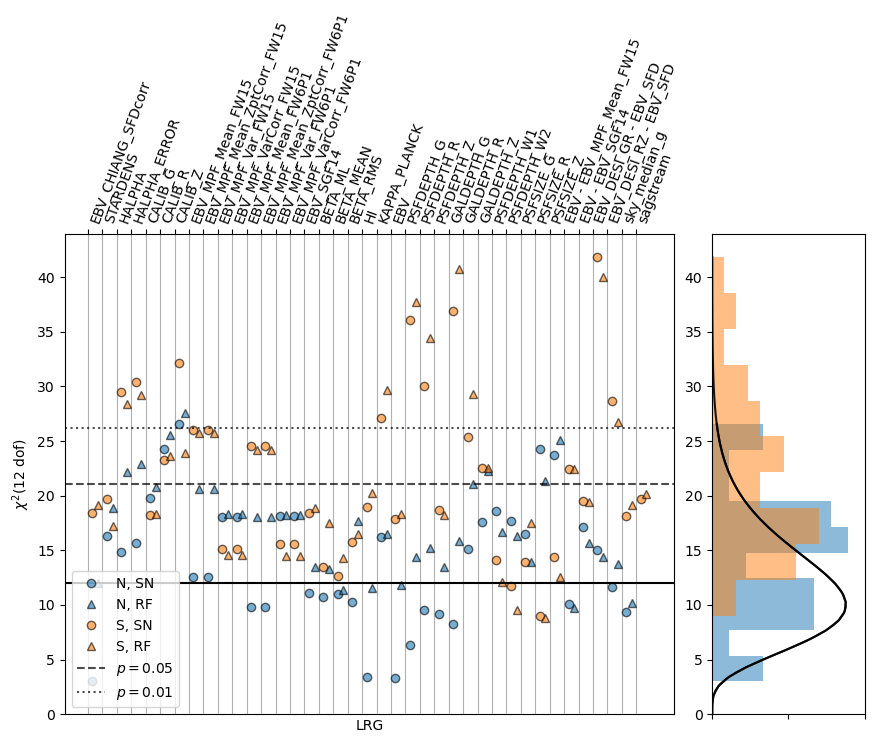

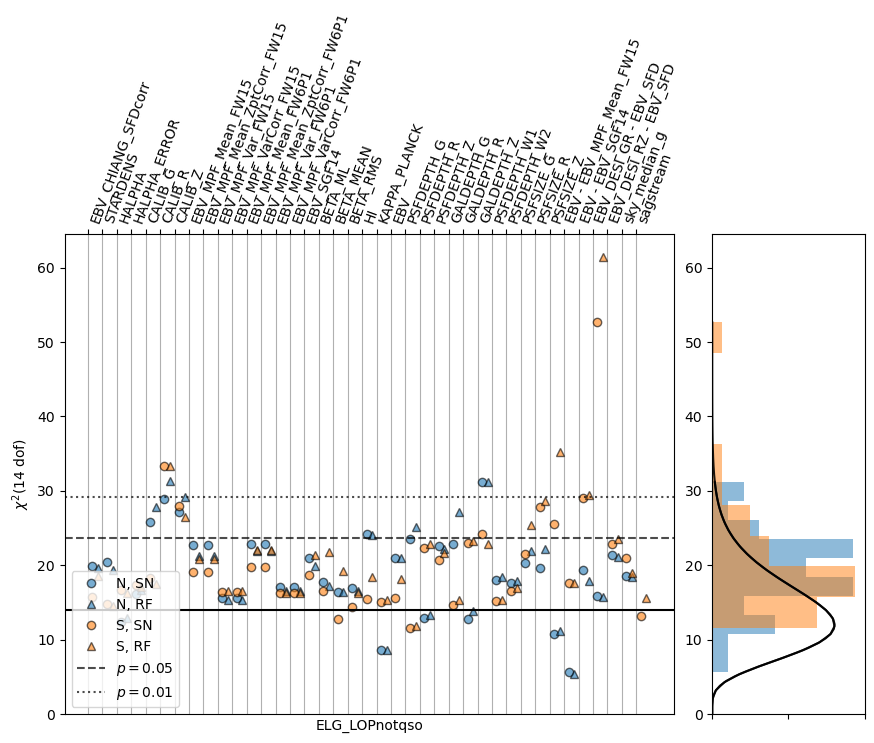

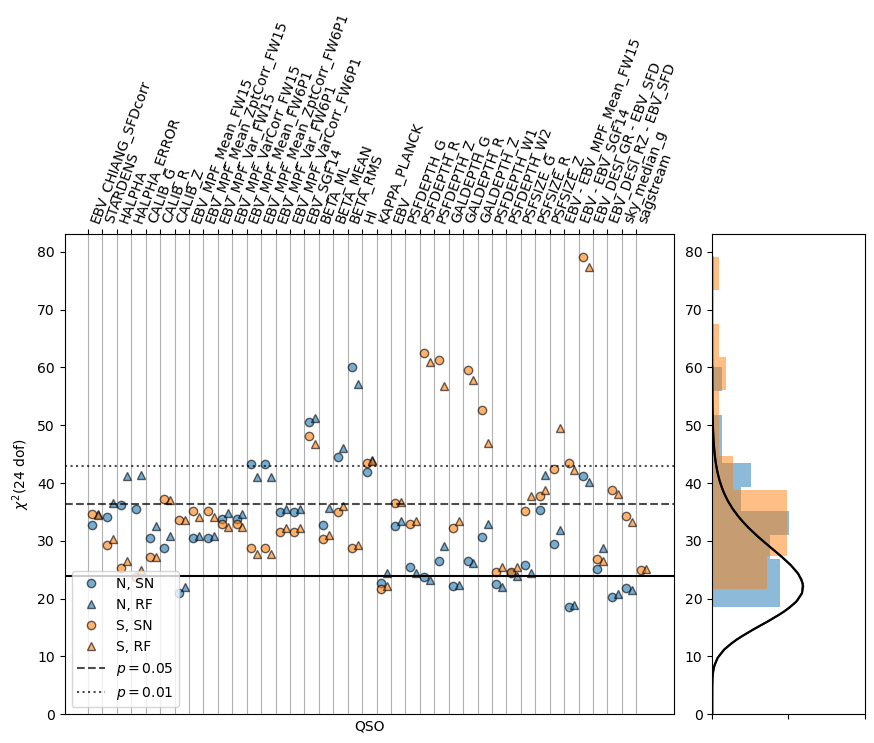

In [26]:
def plot_dchi2_dict(tp, savedir='/global/homes/n/nweaverd/desi/nz_validate/spmap_splits/', 
                    chi2json_dir='/global/homes/n/nweaverd/desi/nz_validate/spmap_splits/'):
    """plot all sp maps and the chi2 of the nz splits.
    tp one of ('LRG', 'ELG_LOPnotqso', 'QSO') """
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.05)

    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharey=ax)

    mslist = ['o', '^']
    for i,NorS in enumerate(('N', 'S')):
        fn = chi2json_dir + f'chi2_splitmap_dict_{NorS}_{tp}_lt40.0_gt60.0.json'
        with open(fn, 'r') as f:
            dchidict = json.load(f)
        
        for j,weightcol in enumerate(['WEIGHT_SN', 'WEIGHT_RF']):
            mydat = [dchidict[key]['region_ratio'][weightcol] for key in dchidict.keys()]
            dof = [dchidict[key]['region_ratio']['dof'] for key in dchidict.keys()]
            assert len(np.unique(dof))==1
            dof = dof[0]
            ax.plot(np.arange(len(mydat))-.2+0.4*j, mydat, mslist[j], alpha=.6, c=f'C{i}', markeredgecolor='k', label=f'{NorS}, {weightcol[-2:]}')
            if j==0:
                ax2.hist(mydat, bins=10, orientation='horizontal', density=True, alpha=.5, color=f'C{i}')
                myx = np.linspace(0,max(mydat))
                ax2.plot(stats.chi2.pdf(myx, dof), myx, c=f'k', alpha=.9)
    ax.axhline(dof, c='k')
    ax.axhline(stats.chi2.isf(0.05, dof), c='k', ls='--', alpha=.7, label='$p=0.05$')
    ax.axhline(stats.chi2.isf(0.01, dof), c='k', ls=':', alpha=.7, label='$p=0.01$')
                         
    ax.set_ylim(ymin=0)
    ax.grid(axis='x')
    ax.set_xticks(ticks=np.arange(len(mydat))-.5, labels=[key for key in dchidict.keys()], rotation=70, ha='left')
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    ax.text(0.5, -.01, tp, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
    ax.set_ylabel(f'$\chi^2 ({dof}$ dof)')
    ax.legend(loc='lower left')
    
    ## plot histogram
    ax2.set_xticklabels([])
    ax2.set_xlim(0, .1)

    if savedir is not None:
        plt.savefig(f'{savedir}/chi2_splitmap_dict_plot_{NorS}_{tp}_lt40.0_gt60.0.png',bbox_inches='tight')
    plt.show()
    return


for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO']:
    plot_dchi2_dict(tp=tracer, chi2json_dir='/global/cfs/projectdirs/desi/users/nweaverd/nweaverd_desi/nz_validate/spmap_splits_v2/')

### Run region validation tests for each tracer

In [27]:
# do_nz_ks_plots('LRG', 'SGC', savedir='nz_validate_0d02', zbinsize=0.02)
# do_nz_ks_plots('LRG', 'NGC', savedir='nz_validate_0d02', zbinsize=0.02)
## no BGS mocks
for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO']:
    print(f'\n\n=============\nNOW DOING {tracer}')
    for gc in ['NGC', 'SGC']:
        do_nz_ks_plots(tracer, gc, savedir='nz_validate_0d02', zbinsize=0.02)


## Plot splitmaps

In [28]:


for name in splitmaps.keys():
    hp.mollview(splitmaps[name], title=name, nest=True, min=np.quantile(splitmaps[name][splitmaps[name]!=0], 0.02), max=np.quantile(splitmaps[name][splitmaps[name]!=0], 0.98))
    

## Covariance estimation

In [15]:
# mock_nz_arrs_s, ksdat_south_mocks = get_mock_nzs('LRG_ffa', gc='SGC')

In [16]:

# _ =plt.hist(np.array(ksdat_south_mocks['unweighted'])[:,0], bins=np.logspace(-30,1), label='Mocks unw', alpha=.8)
# for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
#     # print(key)
#     plt.axvline((ksdat_south['unweighted'][(key)][0]), ls='--', c=f'C{i+1}', label=f"{key}: {ksdat_south['unweighted'][(key)][0]:.1g}")
# plt.legend()
# plt.xscale('log')
# plt.xlim(xmin=1e-30, xmax=1)
# plt.xlabel('KS p-value')
# plt.title('LRG SGC')
# plt.show()

# _ =plt.hist(np.array(ksdat_south_mocks['weighted'])[:,0], bins=np.logspace(-30,1), label='Mocks unw', alpha=.8)
# for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
#     # print(key)
#     plt.axvline((ksdat_south['weighted'][(key)][0]), ls='--', c=f'C{i+1}', label=f"{key}: {ksdat_south['weighted'][(key)][0]:.1g}")
# plt.legend()
# plt.xscale('log')
# plt.xlim(xmin=1e-30, xmax=1)
# plt.xlabel('KS p-value')
# plt.title('LRG SGC')
# plt.show()


# _ =plt.hist(np.array(ksdat_south_mocks['weighted'])[:,1], bins=10, label='Mocks', alpha=.8)
# for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
#     # print(key)
#     plt.axvline((ksdat_south['weighted'][(key)][1]), c=f'C{i+1}', label=f"{key}: {ksdat_south['weighted'][(key)][1]:.1g}")
# plt.legend()
# plt.xlim(xmin=0)
# plt.xlabel('KS stat')
# plt.title('LRG SGC')
# plt.show()

# _ =plt.hist(np.array(ksdat_south_mocks['unweighted'])[:,1], bins=10, label='Mocks', alpha=.8)
# for i,key in enumerate(['WEIGHT_SN', 'WEIGHT_RF', None]):
#     # print(key)
#     plt.axvline((ksdat_south['unweighted'][(key)][1]), ls='--', c=f'C{i+1}', label=f"{key}: {ksdat_south['unweighted'][(key)][1]:.1g}")
# plt.legend()
# plt.xlim(xmin=0)
# plt.xlabel('KS stat')
# plt.title('LRG SGC')
# plt.show()




In [23]:
mydat = (mock_nz_arrs_s['des']/mock_nz_arrs_s['decals'])
mydat.shape

(13, 25)

In [53]:
# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)

X_train = mydat.T

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters, cv=10)
cv.fit(X_train)

GridSearchCV(cv=10, estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01172102, 0.01373824, 0.01610262, 0.01887392,
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ])}])

In [26]:

lw = LedoitWolf(store_precision=True, assume_centered=False)
lw.fit(mydat.T)
oa = OAS(store_precision=True, assume_centered=False)
oa.fit(mydat.T)

OAS()

In [61]:
oa.shrinkage_

0.7580162921582517

In [54]:
cv.cv_results_
# cv.param_grid
# cv.best_estimator_

{'mean_fit_time': array([0.00050466, 0.00046425, 0.00047612, 0.00047591, 0.00047958,
        0.00047917, 0.00047309, 0.00046904, 0.00046597, 0.00046425,
        0.00047252, 0.00047741, 0.00046027, 0.0004827 , 0.00045543,
        0.00045359, 0.00045066, 0.00045269, 0.00046082, 0.00045226,
        0.0004519 , 0.00045271, 0.00045433, 0.00045292, 0.0004494 ,
        0.00045824, 0.00045192, 0.00044827, 0.00044935, 0.00041738]),
 'std_fit_time': array([7.12517464e-05, 5.00883333e-06, 1.69977566e-05, 1.43184004e-05,
        1.48942932e-05, 8.52512297e-06, 7.30825867e-06, 9.50513011e-06,
        1.68317438e-06, 3.07328854e-06, 1.13350170e-05, 4.08257549e-05,
        2.20815380e-05, 4.12782645e-05, 7.57841122e-06, 6.08154343e-06,
        3.77545437e-06, 9.14238106e-06, 1.36257000e-05, 3.34882638e-06,
        8.11758368e-06, 5.81350351e-06, 1.11248265e-05, 8.52128815e-06,
        2.14430971e-06, 1.65284443e-05, 8.57130543e-06, 1.93339681e-06,
        7.93045567e-06, 6.96182251e-06]),
 'mean_scor

In [55]:
cv.cv_results_['mean_test_score']
cv.cv_results_['param_shrinkage'].data

array([0.01, 0.0117210229753348, 0.01373823795883263, 0.01610262027560939,
       0.018873918221350976, 0.022122162910704492, 0.02592943797404667,
       0.03039195382313198, 0.035622478902624426, 0.041753189365604,
       0.04893900918477494, 0.057361525104486784, 0.06723357536499334,
       0.07880462815669913, 0.09236708571873861, 0.10826367338740546,
       0.12689610031679222, 0.1487352107293511, 0.17433288221999882,
       0.20433597178569418, 0.2395026619987486, 0.2807216203941177,
       0.32903445623126676, 0.38566204211634725, 0.4520353656360243,
       0.5298316906283708, 0.6210169418915616, 0.727895384398315,
       0.8531678524172805, 1.0], dtype=object)

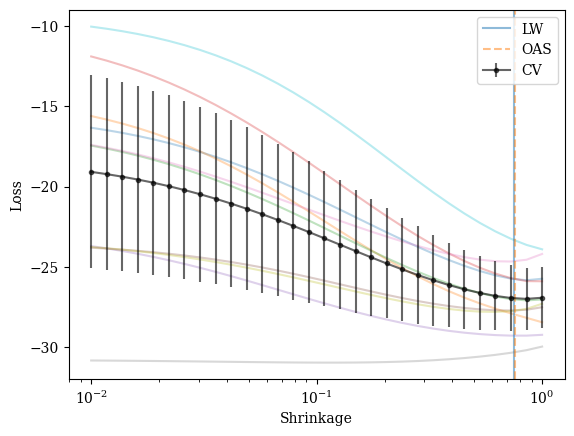

In [66]:
for i in range(cv.n_splits_):
    plt.plot(cv.cv_results_['param_shrinkage'].data, -cv.cv_results_[f'split{i}_test_score'], '-', alpha=.3)
plt.errorbar(cv.cv_results_['param_shrinkage'].data, -cv.cv_results_['mean_test_score'], cv.cv_results_['std_test_score'], marker='.', color='k', alpha=.6, label='CV')
plt.xscale('log')
# plt.
plt.axvline(lw.shrinkage_, alpha=.5, label='LW')
plt.axvline(oa.shrinkage_, alpha=.5, c='C1', ls='--', label='OAS')
plt.xlabel('Shrinkage')
plt.ylabel('Loss')
plt.legend()
# plt.fill_between(cv.cv_results_['param_shrinkage'].data, cv.cv_results_['mean_test_score'] - 

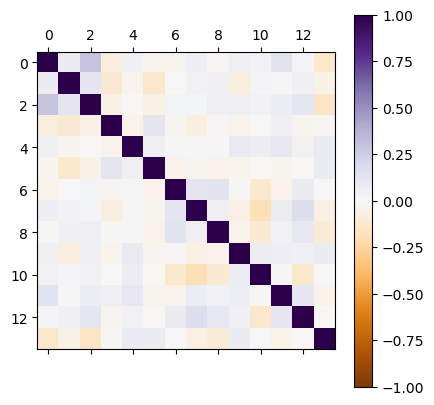

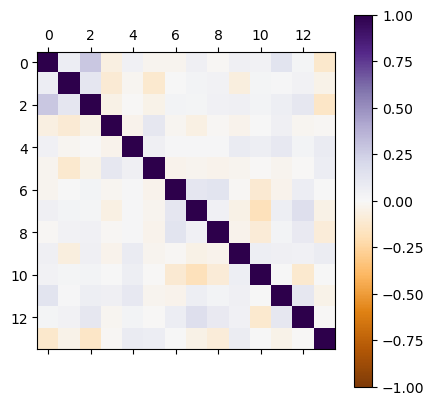

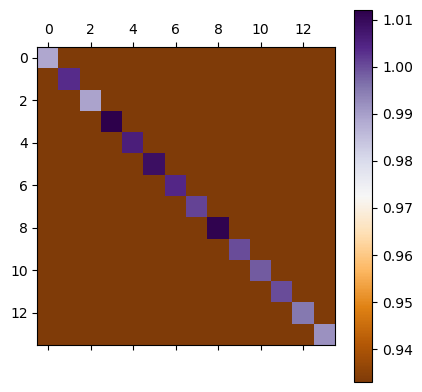

In [104]:
plt.matshow(cov2corr(lw.covariance_), vmin=-1, vmax=1, cmap='PuOr')
plt.colorbar()
plt.show()
plt.matshow(cov2corr(oa.covariance_), vmin=-1, vmax=1, cmap='PuOr')
plt.colorbar()
plt.show()

plt.matshow((oa.covariance_)/(lw.covariance_), cmap='PuOr')
plt.colorbar()
plt.show()

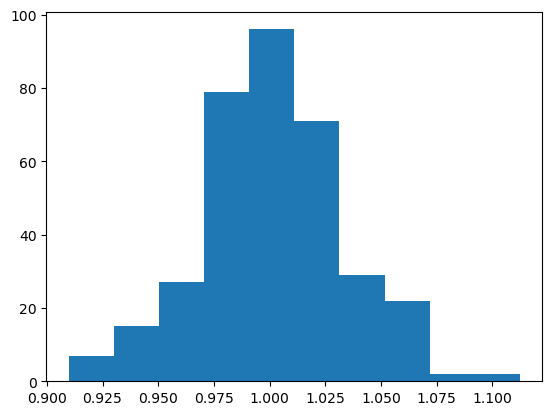

In [87]:
_=plt.hist((mock_nz_arrs_s['des']/mock_nz_arrs_s['decals']).ravel(), bins=10)

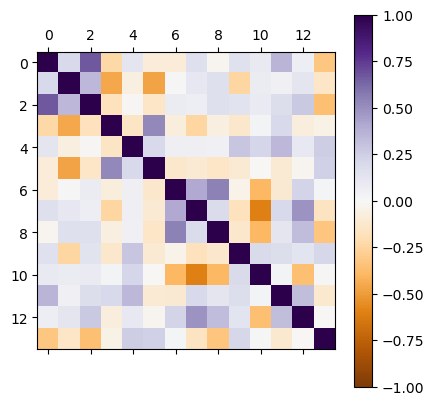

In [76]:
## raw sample covariance
mycov = np.cov(mock_nz_arrs_s['des']/mock_nz_arrs_s['decals'])
# plt.matshow(mycov)
corrmat = mycov/np.sqrt(mycov.diagonal()[:,np.newaxis]*mycov.diagonal()[np.newaxis,:])
plt.matshow(corrmat,vmin=-1, vmax=1, cmap='PuOr')
plt.colorbar()

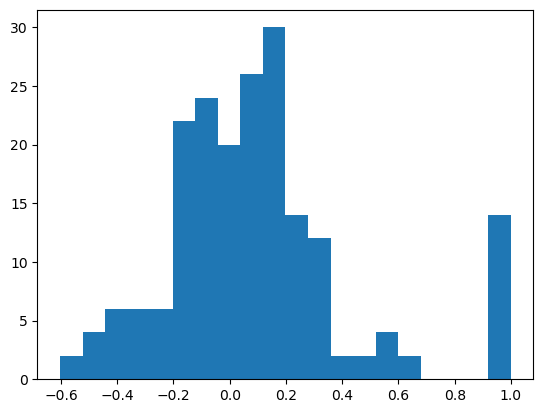

In [80]:
_ = plt.hist(corrmat.ravel(), bins=20)